**Instalaciones**

In [ ]:
!pip install shap imbalanced-learn xgboost matplotlib seaborn --upgrade

**Importaciones**

In [7]:
import warnings
import time
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

**Configuración y Verificación de Hardware**

In [2]:
#configuración de visualización
%matplotlib inline
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

#variable objetivo
TARGET_VARIABLE = "ESTADO_PROGRAMA"

#semilla para reproducibilidad
RANDOM_STATE = 42

#Ruta del dataset
DATA_PATH = Path("/content/drive/MyDrive/Estudios/UNIR/04. Máster en IA/07. TFE/DATA/data_xgboost/dataset_estudiantes_desercion_xgboost.csv")

#Columnas a excluir
EXCLUDE_COLUMNS = [
    "TIPO_DOCUMENTO", "PROGRAMA_COD", "CODPROG_MATRICULA",
    "ASIGNATURA_COD", "GRUPO_ASIG", "COHORTE", "PERIODO_ACADEMICO",
    "ESTADO_ESTUDIANTE_PERIODO", "ESTADO_IES",
    "ESTADO_SISTEMA", "PERIODO_GRADO_PROGRAMA",
    "PERIODO_GRADO_IES", "PERIODO_GRADO_SISTEMA"
]

**Definición de Funciones (Preprocesamiento)**

In [3]:
def load_and_preprocess(filepath, target_col, exclude_cols):

    df = pd.read_csv(filepath, sep=";", encoding="latin1", low_memory=False)

    #exlusión de columnas
    cols_to_drop = exclude_cols + [
        'ID_ESTUDIANTE', 'DOCUMENTO', 'CODPROG_MATRICULA', 'PROGRAMA_COD'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    df_clean = df.drop(columns=cols_to_drop).copy()

    #Limpieza de la variable objetivo
    df_clean = df_clean[df_clean[target_col].notna()]
    df_clean = df_clean[~df_clean[target_col].isin(["SIN INFORMACIÓN", "SIN_INFO"])]

    #Codificación del objetuivo multiclase
    le = LabelEncoder()
    y = le.fit_transform(df_clean[target_col].astype(str))

    #Separación X (características)
    X_raw = df_clean.drop(columns=[target_col])

    #Manejo de cardinalidad
    #Identificamos categóricas y numéricas
    cat_cols = X_raw.select_dtypes(include=['object']).columns
    num_cols = X_raw.select_dtypes(include=['int64', 'float64']).columns

    #Imputación numérica
    for col in num_cols:
        X_raw[col] = X_raw[col].fillna(X_raw[col].median())

    #imputación categórica
    for col in cat_cols:
        moda = X_raw[col].mode()[0] if len(X_raw[col].mode()) > 0 else 'DESCONOCIDO'
        X_raw[col] = X_raw[col].fillna(moda)

    #Solo se codifican variables con <= 20 categorías
    MAX_CATEGORIAS = 20
    cols_a_codificar = []

    for col in cat_cols:
        if X_raw[col].nunique() <= MAX_CATEGORIAS:
            cols_a_codificar.append(col)
        else:
            pass

    print(f"Codificando {len(cols_a_codificar)} variables categóricas (filtro <= {MAX_CATEGORIAS})")

    #Aplicación de One-Hot Encoding
    X_encoded = pd.get_dummies(X_raw, columns=cols_a_codificar, drop_first=True, dtype=int)

    #Eliminación de las columnas categóricas originales que tenían alta cardinalidad y no se codificaron
    X_encoded = X_encoded.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

    #proicesoi de escalado y conversión
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    X_final = X_scaled.astype('float32')

    feature_names = X_encoded.columns.tolist()

    return X_final, y, le, feature_names

**Ejecución: Carga, División y SMOTE (Optimizado RAM)**

Codificando 60 variables categóricas (filtro <= 20)
Datos procesados. 
 Matriz X: (824786, 257)
Clases detectadas: ['Ausente' 'Desertor' 'Graduado']
SMOTE finalizado en 221.70 segundos.
Train Original:   659,828 muestras
Train Balanceado: 802,044 muestras


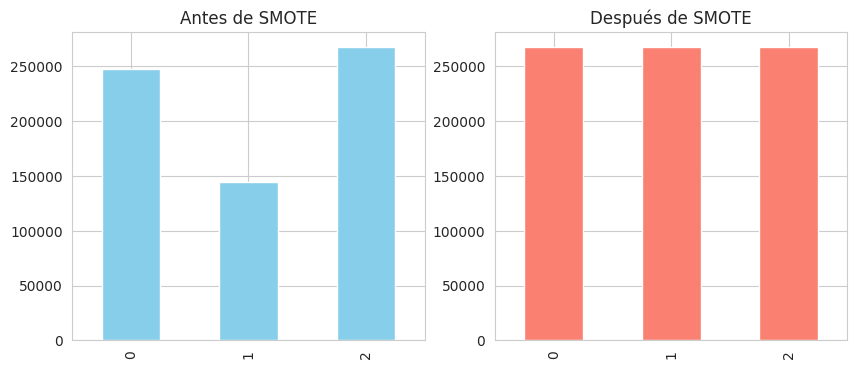

In [4]:
#Preprocesamiento
X, y, label_encoder, feature_names = load_and_preprocess(DATA_PATH, TARGET_VARIABLE, EXCLUDE_COLUMNS)

print(f"Datos procesados. \n Matriz X: {X.shape}")
print(f"Clases detectadas: {label_encoder.classes_}")

#División Train y Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

#aplicación de SMOTE
start_time = time.time()
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"SMOTE finalizado en {time.time() - start_time:.2f} segundos.")
print(f"Train Original:   {X_train.shape[0]:,} muestras")
print(f"Train Balanceado: {X_train_res.shape[0]:,} muestras")

#Visualización
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Antes de SMOTE")
pd.Series(y_train).value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.subplot(1, 2, 2)
plt.title("Después de SMOTE")
pd.Series(y_train_res).value_counts().sort_index().plot(kind="bar", color="salmon")
plt.show()

**Entrenamiento con XGBoost (Optimizado GPU A100)**

In [10]:
#Configuración de parámetros para el modelo
model_params = {
    "n_estimators": 300,
    "max_depth": 8,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": RANDOM_STATE,
    "device": "cuda",
    "tree_method": "hist",
    "predictor": "gpu_predictor"
}


print(f"Modo multiclase ({len(label_encoder.classes_)} clases)")
model = XGBClassifier(objective="multi:softprob", **model_params)

#Entrenamiento
start_train = time.time()
model.fit(X_train_res, y_train_res)
train_time = time.time() - start_train

print(f"Modelo entrenado exitosamente en {train_time:.2f} segundos.")

Modo multiclase (3 clases)
Modelo entrenado exitosamente en 11.77 segundos.


**Evaluación y Métricas**

--- FASE DE EVALUACIÓN FINAL: XGBOOST ---

RESULTADOS PARA: ESTADO_PROGRAMA
Accuracy Global:   0.9258
Macro Recall:      0.9249
Macro F1-Score:    0.9172
Macro AUC-ROC:     0.9863

--- Reporte Detallado ---
              precision    recall  f1-score   support

     Ausente       0.94      0.90      0.92     61928
    Desertor       0.81      0.92      0.86     36192
    Graduado       0.99      0.95      0.97     66838

    accuracy                           0.93    164958
   macro avg       0.91      0.92      0.92    164958
weighted avg       0.93      0.93      0.93    164958



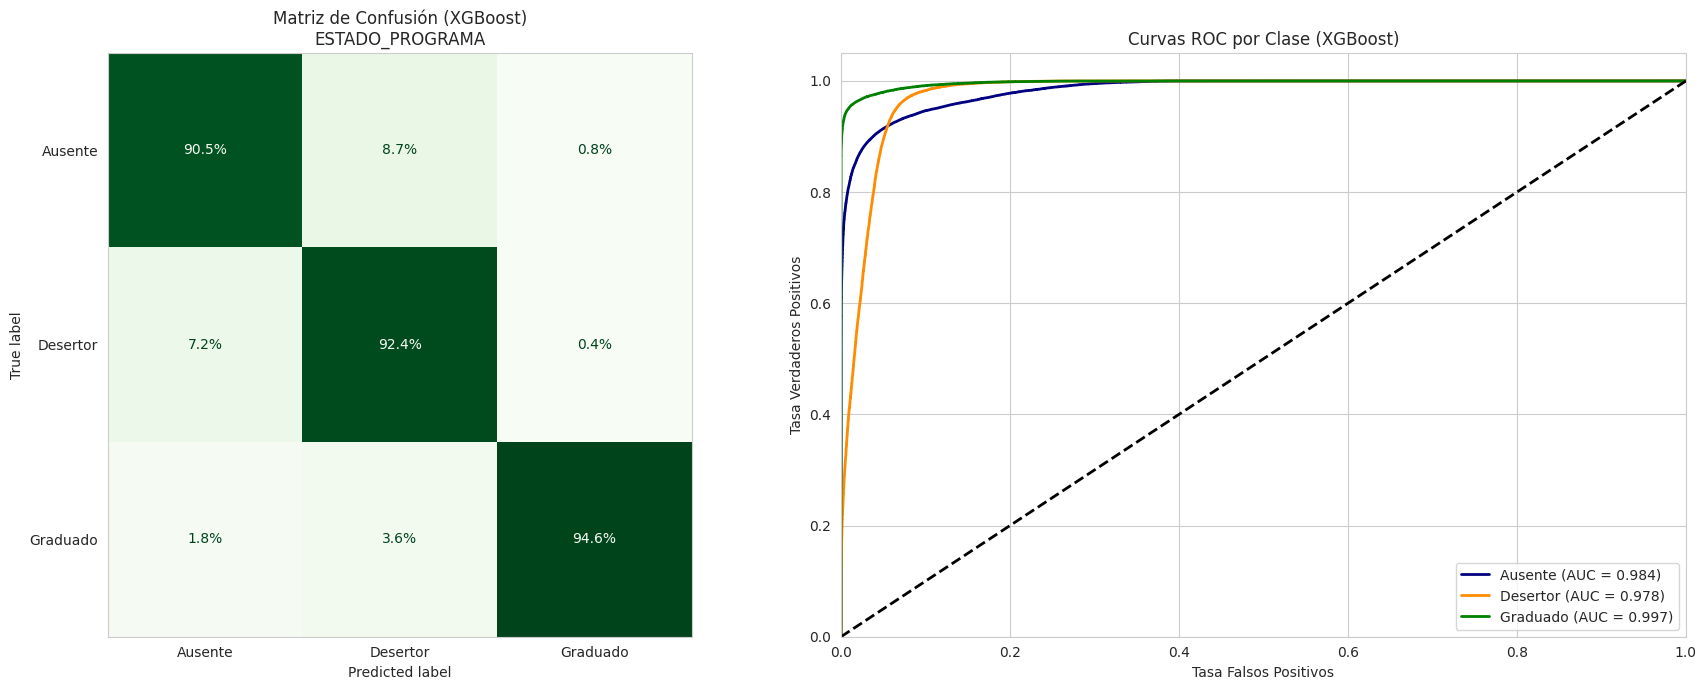

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

print("--- FASE DE EVALUACIÓN FINAL: XGBOOST ---")

#Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

#Métricas
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

#AUC Multiclase (One-vs-Rest)
try:
    auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
except Exception as e:
    print(f"Nota: {e}")
    auc_score = 0.0

print(f"\nRESULTADOS PARA: {TARGET_VARIABLE}")
print("=" * 40)
print(f"Accuracy Global:   {acc:.4f}")
print(f"Macro Recall:      {rec:.4f}")
print(f"Macro F1-Score:    {f1:.4f}")
print(f"Macro AUC-ROC:     {auc_score:.4f}")
print("=" * 40)

#Reporte Detallado
print("\n--- Reporte Detallado ---")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#Gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=label_encoder.classes_,
    cmap='Greens',
    normalize='true',
    values_format=".1%",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title(f'Matriz de Confusión (XGBoost)\n{TARGET_VARIABLE}')
axes[0].grid(False)

#Curvas ROC (One-vs-Rest)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
colors = cycle(['navy', 'darkorange', 'green'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    class_name = label_encoder.classes_[i]
    axes[1].plot(
        fpr, tpr,
        color=color,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc:.3f})'
    )

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa Falsos Positivos')
axes[1].set_ylabel('Tasa Verdaderos Positivos')
axes[1].set_title('Curvas ROC por Clase (XGBoost)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

**Explicabilidad (SHAP)**

<Figure size 1200x1000 with 0 Axes>

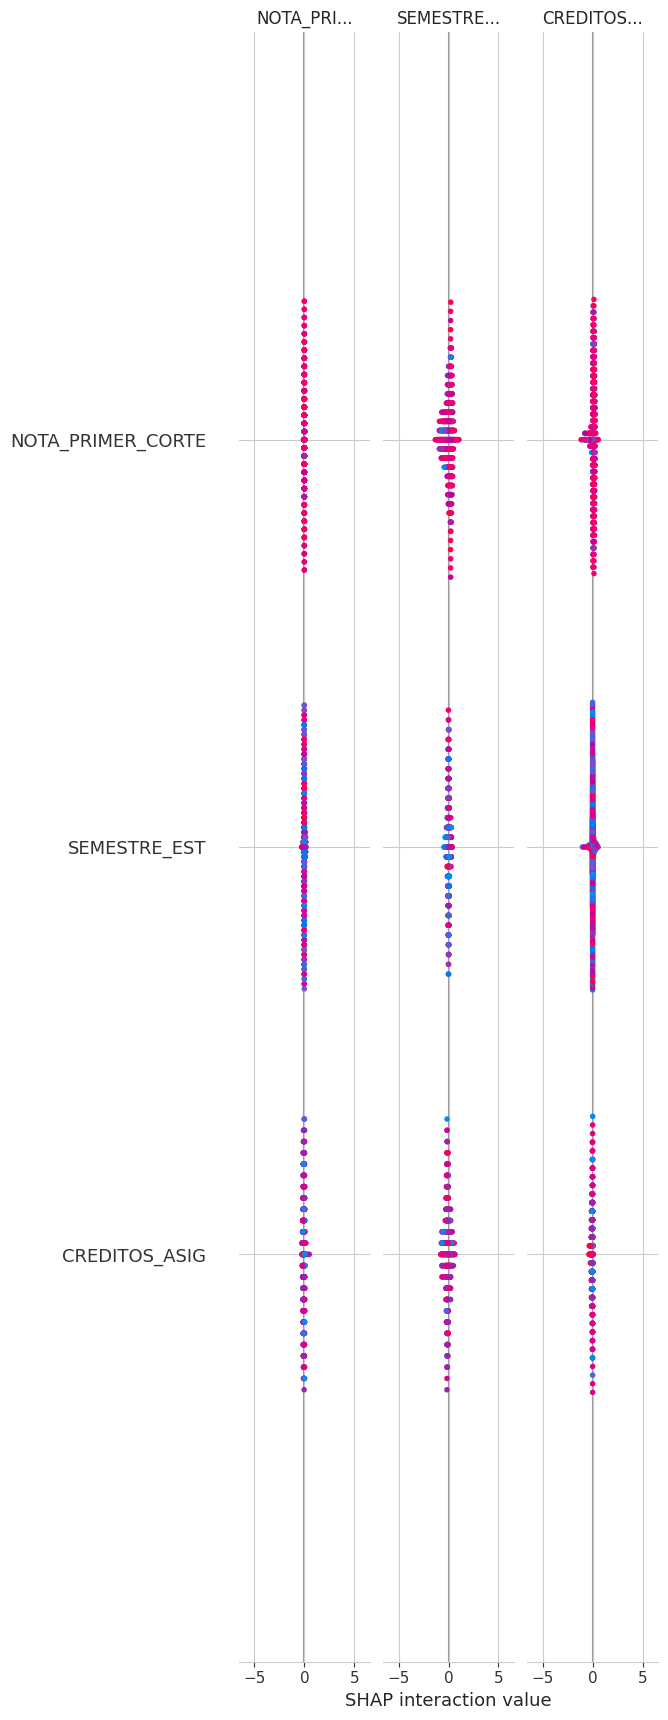

In [13]:
sample_size = 500 #tamaño del ejemplo
if X_test.shape[0] > sample_size:
    indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
    X_sample = X_test[indices]
else:
    X_sample = X_test


#Crear explicador
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

#Si es binario, shap_values a veces es una lista, ajustamos:
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]

plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    pd.DataFrame(X_sample, columns=feature_names),
    max_display=20,
    show=True
)